2023-12-22 09:47:29,474 - 正在请求验证码


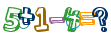

2023-12-22 09:47:34,842 - 正在尝试登录


Exception: 获取token失败，请检查学号或密码或验证码的正确性

In [1]:
import requests
import os
from base64 import b64decode
from PIL import Image
import io
import time
import logging
from IPython.display import display
import json
from Crypto.Cipher import AES
import base64
from urllib.parse import urlencode
logging.captureWarnings(True)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')


class AesUtil:
    '''JavaScript逆向得到的加密方式'''
    def __init__(self,key) -> None:
        self.key=key

    def pkcs7(self, text):
        """明文使用PKCS7填充 """
        bs = 16
        length = len(text)
        bytes_length = len(text.encode('utf-8'))
        padding_size = length if (bytes_length == length) else bytes_length
        padding = bs - padding_size % bs
        padding_text = chr(padding) * padding
        self.coding = chr(padding)
        return text + padding_text

    # 将明文用AES加密
    def aes_encrypt(self, data):
        # 将长度不足16字节的字符串补齐
        #if len(data) < 16:
        data = self.pkcs7(data)
        AES_obj = AES.new(self.key.encode("utf-8"), AES.MODE_ECB)
        AES_en_str = AES_obj.encrypt(data.encode("utf-8"))
        AES_en_str = base64.b64encode(AES_en_str)
        AES_en_str = AES_en_str.decode("utf-8")
        return AES_en_str
    def aes_decrypt(self, data):
        """AES解密 """
        cipher = AES.new(self.key, AES.MODE_ECB)
        data = base64.b64decode(data)
        text = cipher.decrypt(data).decode('utf-8')
        return text.rstrip(self.coding)

class XMUCourseEntroller:
    def __init__(self, student_id, password) -> None:
        self.token = None
        self.aesutil = AesUtil('MWMqg2tPcDkxcm11')
        self.__student_id = student_id
        self.__password = self.aesutil.aes_encrypt(password)  # 密钥是固定的
        self.course_list = {}
        self.session = requests.Session()

    def login(self):
        '''传入学号的加密后的密码，获得身份认证token'''
        headers = {
            'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
        }
        captcha_url = 'http://xk.xmu.edu.cn/xsxkxmu/auth/captcha'
        try:
            logging.info('正在请求验证码')
            response = self.session.post(
                captcha_url, headers=headers)  # 不允许get方法
        except:
            raise '请求验证码失败'
        image_data = response.json()['data']['captcha'].split(',')[
            1]  # 获取base64原字符
        uuid = response.json()['data']['uuid']  # 参数验证
        b64_data = b64decode(image_data)  # 编码为base64
        image = Image.open(io.BytesIO(b64_data))
        # image.show()
        display(image)  # 显示在单元格下方
        captcha = input('输入captcha的内容')
        data = {
            'loginname': self.__student_id,
            'password': self.__password,
            'captcha': captcha,
            'uuid': uuid
        }
        logging.info('正在尝试登录')
        login = self.session.post(
            'http://xk.xmu.edu.cn/xsxkxmu/auth/login', data=data, allow_redirects=False, headers=headers)
        try:
            token = login.json()['data']['token']  # 获取JWT身份认证
        except:
            raise Exception('获取token失败，请检查学号或密码或验证码的正确性')
        else:
            logging.info('成功获取token')
            self.token = token

    def query_course_list(self, classtypes: list, delay: float = 1):
        '''获取可选课程列表，可以选择哪种课程，返回课程目前人数，人数上限，
        教师 课程密钥 课程名称 课程classid 并存储到本地'''
        if not self.token:
            logging.error('请先登录！')
            return
        infos = {}
        headers = {
            'Authorization': self.token,
            'Content-Type': 'application/json;charset=UTF-8',  # 必须加这个，不然会返回html
            'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
        }
        list_url = 'http://xk.xmu.edu.cn/xsxkxmu/elective/clazz/list'
        for classtype in classtypes:
            # session = requests.Session() #这里不开新会话会报错403 因为太快了
            payload = "{"+f'\"teachingClassType\":\"{classtype}\",\"pageNumber\":1,\"pageSize\":10,\"orderBy\":\"\",\"campus\":\"1\"'+"}"
            courses = self.session.post(
                list_url, headers=headers, data=payload)

            # 比如五个课程只要遍历1页，15个课程遍历2页
            page_num = (json.loads(courses.text)['data']['total']//10)+1

            logging.info(f'获得课程类型:{classtype}共{page_num}页数')
            for pageNumber in range(1, page_num+1):  # 一旦满课程数返回空字典就break 这里只是一个上限
                payload = "{"+f'\"teachingClassType\":\"{classtype}\",\"pageNumber\":{pageNumber},\"pageSize\":10,\"orderBy\":\"\",\"campus\":\"1\"'+"}"
                courses = self.session.post(
                    list_url, headers=headers, data=payload)
                if json.loads(courses.text)['code'] == 403:
                    logging.error('我想你可能爬得太快了')
                    raise Exception('爬虫过快')
                rows = json.loads(courses.text)['data']['rows']
                course_data = rows  # 获取字典 一行中有多个课程
                logging.info(f'正在提取{classtype}的第{pageNumber}页信息')
                for course in course_data:
                    try:
                        data = course['tcList'][0]
                    except:
                        data = course  # 校选课没有tcList
                    info = {
                        'SKJS': data['SKJS'],  # 课程教师
                        'JXBID': data['JXBID'],  # 课程id
                        'numberOfSelected': data['numberOfSelected'],  # 课程选中数
                        'classCapacity': data['classCapacity'],  # 课程容量
                        'secretVal': data['secretVal'],  # 课程密钥
                        'classType': classtype,
                        'numberOfFirstVolunteer': data['numberOfFirstVolunteer']
                    }
                    infos[data['KCM']] = info
                time.sleep(delay)  # 建议设置 不然会403（辅导员警告）
        self.course_list = infos
        try:
            with open('课程信息.json', 'wx') as f:
                f.write(json.dumps(infos, ensure_ascii=False, indent=2))
                logging.info(f'成功生成本地课程信息,共{len(infos)}条')
        except:
            with open('课程信息.json', 'w') as f:
                f.write(json.dumps(infos, ensure_ascii=False, indent=2))
                logging.info(f'成功覆盖本地课程信息,共{len(infos)}条')

    def change_course(self, name: str, type: str):
        '''根据名字选取或者退出课程,type可以是add或del'''
        course_info = self.course_list[name]
        logging.info(
            f'正在尝试修改课程:{name},当前选择人数{course_info["numberOfSelected"]},\n当前志愿人数{course_info["numberOfFirstVolunteer"]},课容量上限{course_info["classCapacity"]}')
        if type == 'del':
            url = "http://xk.xmu.edu.cn/xsxkxmu/elective/clazz/del"
        elif type == 'add':
            url = "http://xk.xmu.edu.cn/xsxkxmu/elective/clazz/add"
        else:
            raise Exception('请输入del或者add，分别是退课和选课')

        header = {
            'Authorization': self.token,
            'Content-Type': 'application/x-www-form-urlencoded',
            'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36',
        }

        payload = {
            'clazzType': course_info["classType"],
            'clazzId': course_info["JXBID"],
            'secretVal': course_info["secretVal"],
            'needBook': '',
            'chooseVolunteer': 1,
        }
        response = self.session.post(
            url, headers=header, data=urlencode(payload))  # 必须要urlencode,不然会出错！
        if json.loads(response.text)['msg'] == '操作成功':
            if type == 'add':
                logging.info(f'成功选取课程{name}')
                return True
            else:
                logging.info(f'成功退选课程{name}')
                return True
        else:
            if type == 'add':
                logging.error(
                    f'选取{name}失败,请检查系统消息:{json.loads(response.text)["msg"]}')
                return False
            else:
                logging.error(
                    f'退选{name}失败,请检查系统消息:{json.loads(response.text)["msg"]}')
                return False

    def loop_add_course(self, name, delay=0.3, loop_num=20):
        '''循环抢课'''
        for i in range(1, loop_num+1):
            if self.change_course(name, 'add'):
                logging.info(f'循环抢课成功,共执行了{i}次')
                time.sleep(0.3)
                break
            time.sleep(delay)


if __name__ == '__main__':
    PASSWORD = 'KiSTUepEu3Sk1t+NDBtsrw=='  # 输入你的密码,其会被自动加密
    ID = '37220232203813' #你的学号
    TEACHINGCLASSTYPE = {
        '校选课': 'XGKC',
        '本专业计划课程': 'TJKC',
        '本专业其他年级课程': 'FANKC',
        '体育课程': 'TYKC',
    }
    COURSE_LIST = ['商业社会与现代中国', '国际经济与贸易学科前沿系列课程',
                   '统计学与数据科学业界系列讲座', '文献检索管理与分析']  # 课程列表
    xmu = XMUCourseEntroller(ID, PASSWORD)
    xmu.login()  # 登录
    xmu.query_course_list(TEACHINGCLASSTYPE.values(),
                          delay=1)  # 由于每次密钥不一样,建议每次都读取一次

    for course in COURSE_LIST:  # 演示用
        xmu.change_course(course, 'del')  # 退课
        xmu.loop_add_course(course)